By Nick Newton

ncn6mq@virginia.edu

(804) 937-3494

Github: https://github.com/ncn6mq

# Baseline $\chi^2$ minimization fit

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as optimization

Import dvcs_cross dataset.  In this notebook I will be working with the first set of kinematics (index 0-35 inclusive).

In [5]:
comp_folder = '../Compton_FF_Code/'

df = pd.read_csv(comp_folder + 'DVCS_cross.csv')

Import bhdvcs function.  This is [Teddy's version from his github](https://github.com/tvallar/ptgroupneuralnet/blob/master/Compton_FF_Code/BHDVCS.py).

In [13]:
from BHDVCS import BHDVCS
bhdvcs = BHDVCS()
total_uuxs = bhdvcs.TotalUUXS_curve_fit #this is a function but I wanted to rename it for use in curve_fit function

## Setup for curve fit and curve fit

In the next two cells I create set up the parameters (compton form factors) will be used by the [scipy optimization curve_fit function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit). I create a dataset of parameters of first set of kinematics (this is X).  They are given in the order that the TotalUUXS_curve_fit specifies.

In [23]:
X = df.loc[:35, ['phi_x', 'QQ', 'x_b', 't', 'k']]
X['const'] = 0.014863 # This is a constant needed by the total_uuxs function (constant given by Prof. Keller)

In [128]:
y = df.loc[:35, 'F']
sigma = df.loc[:35, 'errF']
pars0 = np.asarray([0, 0, 0]) #starting guesses for the parameters ReH, ReE, ReHTilde (in that order)

In [56]:
res = optimization.curve_fit(total_uuxs, X, y, pars0, sigma, method='lm')

## Result of curve fit

In [57]:
cff, cffcov = res

In [133]:
cffcov #Covariance matrix of fitted parameters

array([[ 5.74424134e+12, -9.16907483e+12, -1.18747921e+12],
       [-9.19054169e+12,  1.47071930e+13,  2.97867200e+12],
       [-1.81228544e+12,  3.97156267e+12,  3.17725014e+13]])

In [287]:
perr = np.sqrt(np.diag(cffcov))

Parameters resulting from curve_fit compared to correct parameters from dataset.

In [289]:
pd.DataFrame({'Fitted': cff, 'Correct':df.loc[0, ['ReH', 'ReE', 'ReHTilde']].values, 'Error': perr}, ['ReH', 'ReE', 'ReHTilde'])

Fitted   Correct         Error
ReH       0.279011  0.631324  2.396715e+06
ReE       0.746073  0.955970  3.834996e+06
ReHTilde -0.281310  0.852383  5.636710e+06

### Summary

I ran a $\chi^2$ minimization curve fit to extract the parameters for total_uuxs function.  I used the levenberg-marquardt algorithm (a method that does not require bounds), and starting parameters of 0, 0, 0 for ReH, ReE, and ReHTilde, respectively.  Only one parameter was remotely close -- ReE.  Furthermore, the error was massive.  I need to further examine what is causing the error to be so large in my fit.

### Run total_uuxs with fit parameters for graphing purposes

In [61]:
pars = df.loc[:35, ['QQ', 'x_b', 't', 'k', 'F1', 'F2']]
pars['ReH'] = cff[0]
pars['ReE'] = cff[1]
pars['ReHTilde'] = cff[0]
pars['const'] = 0.014863
phis = df.loc[:35, 'phi_x']

In [65]:
fs_g_pars = []
for i in range(36):
    fs_g_pars.append(bhdvcs.TotalUUXS([phis[i]], pars.loc[i, :]))

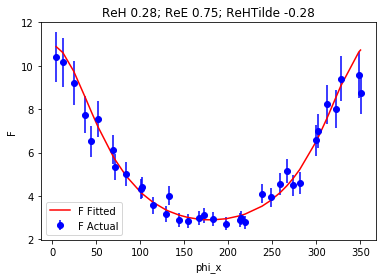

In [88]:
fig, ax = plt.subplots()
ax.plot(phis, fs_g_pars, '-r', label='F Fitted')
ax.errorbar(phis, df.loc[:35, 'F'], yerr=df.loc[:35, 'errF'], fmt='bo', label='F Actual')
ax.set_xlabel('phi_x')
ax.set_ylabel('F')
ax.set_title('ReH 0.28; ReE 0.75; ReHTilde -0.28')
leg = ax.legend();

### Graph discussion

The red line graphs the results of the total_uuxs function when the fitted parameters are used.  The blue dots represent the actual F values from the dataset and the error bars are from the standard error given in the dataset by errF.  Just from a visual inspection, it appears that the curve using the fitted parameters is a very good fit.

### $\chi^2/dof$

In [118]:
def chi2overdof(y, yhat, err): # accepts any iterable
    assert len(y) == len(yhat) == len(err)
    n = len(y)
    cumsum = 0
    for i in range(n):
        cumsum += ((y[i] - yhat[i])/err[i])**2
    return cumsum/n

In [119]:
chi2overdof(df.loc[:35, 'F'], fs_g_pars, df.loc[:35, 'errF']) 

0.7059431251342028

### $\chi^2/dof$ with given cffs as reference

In [92]:
pars = df.loc[:35, ['QQ', 'x_b', 't', 'k', 'F1', 'F2', 'ReH', 'ReE', 'ReHTilde']]
pars['const'] = 0.014863
# still have the same phis from test above

In [120]:
fs_g_pars = []
for i in range(36):
    fs_g_pars.append(bhdvcs.TotalUUXS([phis[i]], pars.loc[i, :]))

In [121]:
chi2overdof(df.loc[:35, 'F'], fs_g_pars, df.loc[:35, 'errF']) 

0.683156338546961

### Discussion of $\chi^2/dof$

The $\chi^2/dof$ with the fitted compton form factors is higher than that of the with the given compton form factors, as expected.  However, theses values are remarkably close despite fairly different compton form factors, perhaps implying a [function space with many local minima](https://en.wikipedia.org/wiki/Rastrigin_function). This would explain the general difficulty encountered by the gradient-based optimization methods used in Teddy's work. This hypothesis is explored below.

## Visualization of function space

**This section is still a work in progress.**  In the interest of getting this notebook out in a timely manner I'm leaving it incomplete for now.

In this section I explore the quality of fit as measured by $\chi^2/dof$ as a function of the compton form factors.  Unfortunately this is a three-dimensional input space which doesn't lend itself easily to visualization. If anyone has better suggestions for visualization than what I've done here please email/text me.

In [122]:
pars = df.loc[0, ['QQ', 'x_b', 't', 'k', 'F1', 'F2']]
pars['ReH'] = 0
pars['ReE'] = 0
pars['ReHTilde'] = 0
pars['const'] = 0.014863

I calculate the $\chi^2/dof$ for each combination of reh, ree, and rehtilde between 0 and 1, stepping by .01.  This range was chosen somewhat arbitrarily, but it probably serves my purpose just as well as any other range. I probably should have written this in C++ because it took 6 hours to run.

In [135]:
pars

QQ          1.723950
x_b         0.355194
t          -0.205368
k           2.750000
F1          0.631324
F2          0.955970
ReH         0.000000
ReE         0.000000
ReHTilde    0.000000
const       0.014863
Name: 0, dtype: float64

In [143]:
from tqdm import tqdm

vals = []
for reh in tqdm(range(100)):
    for ree in range(100):
        for rehtilde in range(100):
            pars['ReH'] = reh/100
            pars['ReE'] = ree/100
            pars['ReHTilde'] = rehtilde/100
            fs_g_pars = []
            for i in range(36):
                fs_g_pars.append(bhdvcs.TotalUUXS([phis[i]], pars))
            vals.append(((reh/100, ree/100, rehtilde/100), chi2overdof(df.loc[:35, 'F'], fs_g_pars, df.loc[:35, 'errF'])))
            

100%|██████████| 100/100 [6:34:13<00:00, 236.54s/it]   


In [277]:
chi2 = [x[1] for x in vals]
inputs = [x[0] for x in vals]

In [278]:
inputs = np.asarray(inputs)
chi2 = np.asarray(chi2)

Display min and max for all $\chi^2/dof$ across all sets of compton form factors between 0 and 1.

In [284]:
chi2.min(), chi2.max()

(0.6670652401466257, 0.7464976752057193)

Display compton form factor value that gives lowest $\chi^2/dof$

In [285]:
vals[np.argmin(chi2)]

((0.0, 0.0, 0.98), 0.6670652401466257)

In [290]:
vals

[((0.0, 0.0, 0.0), 0.7238351261987708),
 ((0.0, 0.0, 0.01), 0.7226860465761888),
 ((0.0, 0.0, 0.02), 0.7215487153055871),
 ((0.0, 0.0, 0.03), 0.720423132386965),
 ((0.0, 0.0, 0.04), 0.7193092978203232),
 ((0.0, 0.0, 0.05), 0.7182072116056613),
 ((0.0, 0.0, 0.06), 0.7171168737429793),
 ((0.0, 0.0, 0.07), 0.7160382842322773),
 ((0.0, 0.0, 0.08), 0.7149714430735553),
 ((0.0, 0.0, 0.09), 0.7139163502668134),
 ((0.0, 0.0, 0.1), 0.7128730058120514),
 ((0.0, 0.0, 0.11), 0.7118414097092691),
 ((0.0, 0.0, 0.12), 0.7108215619584671),
 ((0.0, 0.0, 0.13), 0.7098134625596451),
 ((0.0, 0.0, 0.14), 0.7088171115128029),
 ((0.0, 0.0, 0.15), 0.7078325088179409),
 ((0.0, 0.0, 0.16), 0.7068596544750587),
 ((0.0, 0.0, 0.17), 0.7058985484841565),
 ((0.0, 0.0, 0.18), 0.7049491908452344),
 ((0.0, 0.0, 0.19), 0.7040115815582926),
 ((0.0, 0.0, 0.2), 0.7030857206233304),
 ((0.0, 0.0, 0.21), 0.7021716080403485),
 ((0.0, 0.0, 0.22), 0.701269243809346),
 ((0.0, 0.0, 0.23), 0.7003786279303239),
 ((0.0, 0.0, 0.24), 0

Plot $\chi^2/dof$ as a function of ReE and ReHTilde across all values of ReH

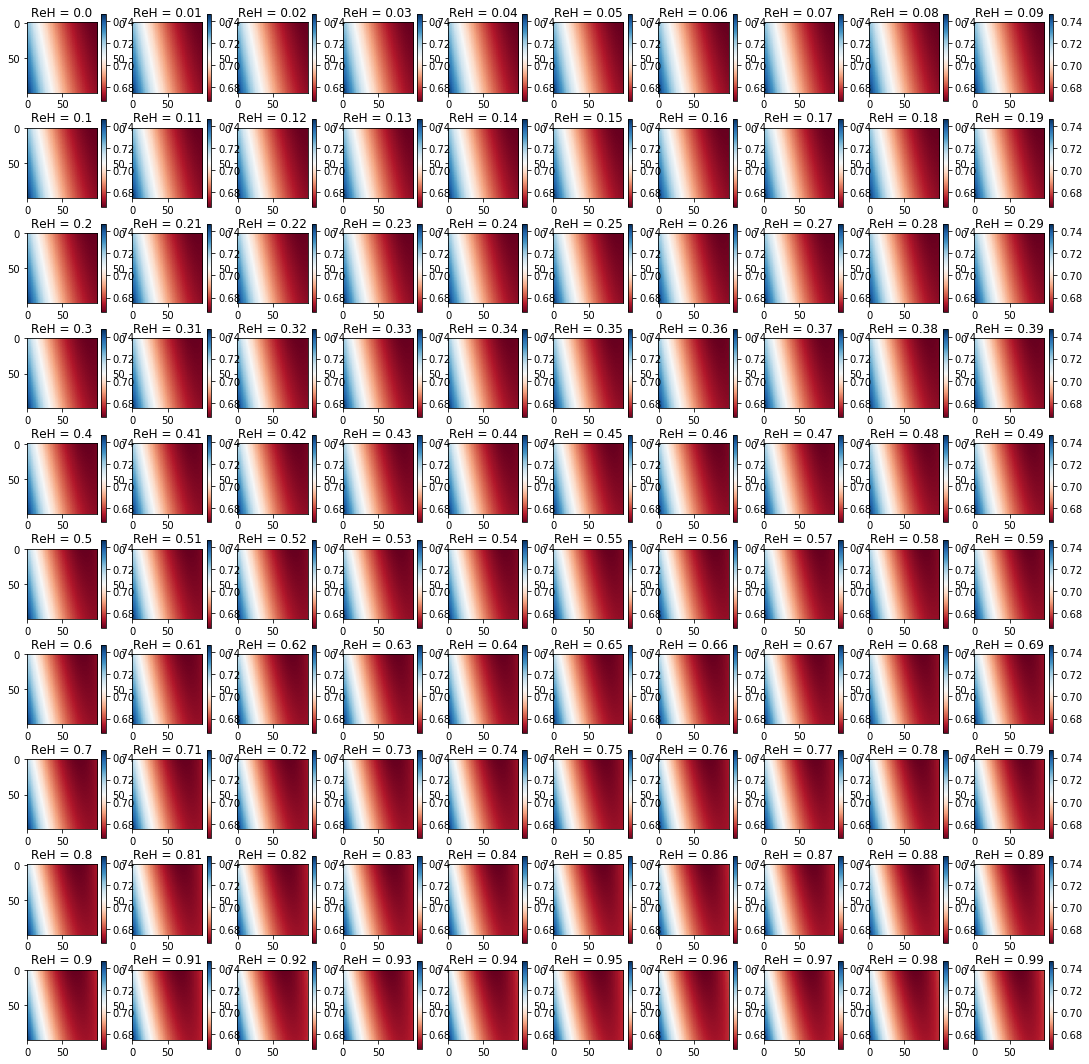

In [282]:
fig,a =  plt.subplots(10, 10, figsize=(5, 5))
fig.subplots_adjust(right=3, top=3)
for i in range(10):
    for j in range(10):
        slicenum = i*10+j
        #print(slicenum)
        #print((slicenum*10000), ((slicenum+1)*10000))
        chi2slice = np.reshape(chi2[(slicenum*10000):((slicenum+1)*10000)], (100, 100))
        a[i, j].imshow(chi2slice,cmap=cm.RdBu)
        a[i, j].set_title('ReH = ' + str(slicenum/100))
        fig.colorbar(im, ax=a[i, j])

show()

## Summary

I think I must have done something wrong because the plots are identical across different ReH values.  I'll hopefully have this all cleared up before the next meeting.  I also need to expand the ranges, as the $\chi^2/dof$ value is still decreasing at the top of the plot, so we dont get a clear look at any minimum.  

Additionally, a concerning result of this work is that I did find a lower $\chi^2/dof$ than that of the given, assumed to be correct, compton form factors from the dataset.  Compton form factors 0.0, 0.0, 0.98 for ReH, ReE, and ReHTilde, respectively, give a $\chi^2/dof$ value of 0.667 as compared to 0.683 with the compton form factors from the dataset.

# Additional Resources

1. https://www.jlab.org/conferences/qcd2014/wed-am/Kresimir_Kumericki.pdf
2. https://en.wikipedia.org/wiki/Global_optimization